<a href="https://colab.research.google.com/github/MaxwellMkondiwa/dataAnalytics-DSA2021/blob/master/cassava_disease_classification_modelmaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2021 DSA.
Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2021 DSA. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Predicting crop disease in cassava plants from images of their leaves
This is a DSA summer school Computer Vision lab. The goal is to be able to build a robust disease classifier that can be ported to a mobile device like a smartphone for use in the field by a small-holder farmer.

Goals:
- Explore building a disease classifier with state of the art tools in Tensorflow
- Quickly apply transfer learning to minimize compute and build on previous work.
- Build robustness in model by adding additional class
- Use resources already built on Tf-Hub

## Clone GitHub repo with start materials

In [ ]:
# Clone GitHub repo with materials
!git clone https://github.com/emwebaze/dsa2020cv.git

Cloning into 'dsa2020cv'...
remote: Enumerating objects: 589, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 589 (delta 7), reused 9 (delta 1), pack-reused 569
Receiving objects: 100% (589/589), 34.69 MiB | 38.57 MiB/s, done.
Resolving deltas: 100% (9/9), done.


## Installs and imports
We will leverage some of the latest tools in the Tensorflow toolbox particularly [Model Maker](https://www.tensorflow.org/lite/guide/model_maker), so lets install this and a few other necessary imports.

In [ ]:
!pip install tflite-model-maker
!pip install tensorflow-datasets -U

In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tflite_model_maker import image_classifier
from tflite_model_maker.image_classifier import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
#@title Helper function for displaying images

def plot_25_images(data, trained_model=None):
  plt.figure(figsize=(15,15))
  if trained_model: predicted = model.predict_top_k(data)
  for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
    ax = plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)
    if trained_model:
      predict_label = predicts[i][0][0]

      # Set prediction color
      true_label = data.index_to_label[label.numpy()]
      color = 'green' if predict_label ==  true_label else 'red'
      ax.xaxis.label.set_color(color)
      plt.xlabel('Predicted: %s (True: %s)' % (predict_label, true_label))
    else:
      plt.xlabel(data.index_to_label[label.numpy()])
  plt.show()


# Defining the problem
The goal of computer vision is visual recognition from images and/or videos. Videos can be thought of as a sequence of images (or frames). The most basic, perhaps most common task in visual recognition is image classification. Given an image can we categorize it correctly. For example the disease diagnosis problem we want to tackle in this notebook; given a leaf image can we correctly predict which class of disease the image represents.

Images are particularly important in the African context as a unique data type that transcends the many languages spoken by different people in Africa. For example an image diagnosis application on a mobile phone is easily usable by every farmer who has a smartphone because there is hardly any text she/he is required to read. They point the phone at a plant, take an image and get a big green tick for OK or a big red "X" for sick plant. Other more literate farmers can be trained to read the actual disease and how confident the predictive model is.

## Load the dataset
The dataset consists of a small number of images 537 in total from 5 classes
- health : the Healthy class
- cmd : Cassava Mosaic Disease infected leaf images
- cbb : Cassava Bacterial Blight leaf images
- cbsd : Cassava Brown Streak Disease
- cgm : Cassava Green Mite disease infected images

In [ ]:
# Load the cassava data from the GitHub repo
data = DataLoader.from_folder('dsa2020cv/pdata/')
train_data, test_data = data.split(0.9)

INFO:tensorflow:Load image with size: 537, num_label: 5, labels: cbb, cbsd, cgm, cmd, healthy.


## Display some cassava leaf images

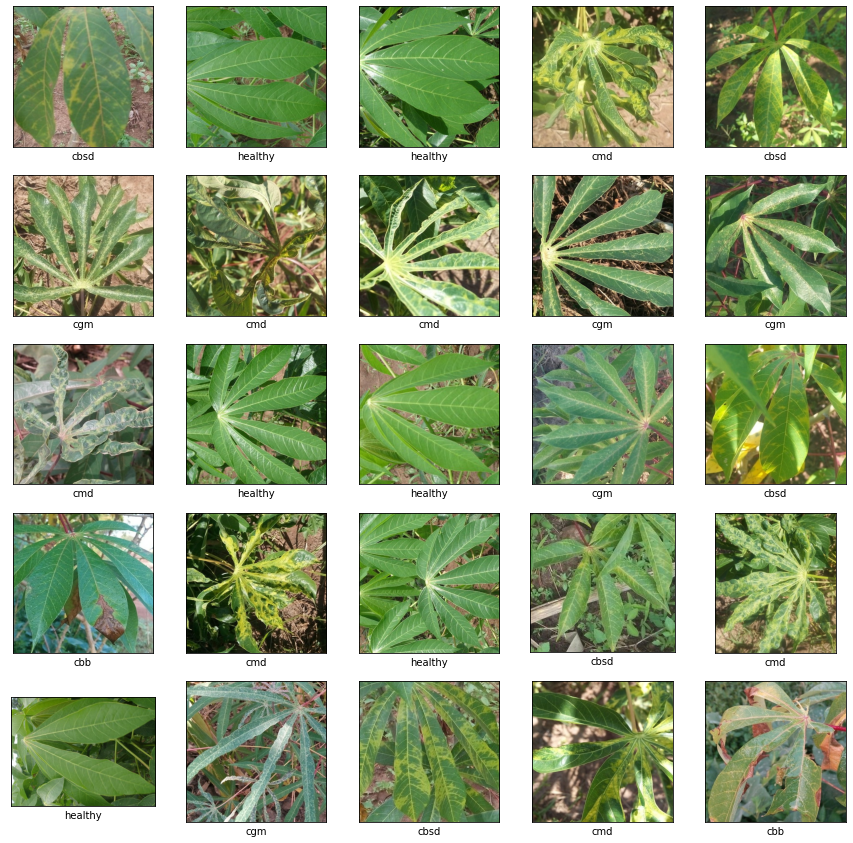

In [ ]:
plot_25_images(test_data)

The images form a typical fine-grained classification problem where there is large intra-class variation and small inter-class variation, particularly for the diseased image classes.

## Modeling
The goal is to build some type of model that can take an image and predict disease. As you have probably learnt in the machine learning module, the process of building a good predictor involves selecting a model class and fitting it to some training dataset, a process surprisingly called `training`. Our trained model is then our predictor that we can use to predict in our case diseases from other cassava plants not used in the training. 

Ordinarily it may be good to train our model from scratch with these images. However the small sizes will most likely give us poor results particularly as the problem is close to a fine-grained computer vision problem. 

If you want to go through the process of training from scratch and gradually improving you can take a look at the notebook in the downloaded GitHub repo called `cassava_disease_prediction_from_basics.ipynb`. Also [accessible from here](https://colab.research.google.com/drive/1jZnTrSCW8tPl-vWPjs4MCVzncyAd0QN1?usp=sharing).

## Modeling with Model Maker
We shall use a tensorflow tool Model Maker which is specifically optimized to create models that can be quantized and ported to mobile devices like smartphones. If offers quick ways of fine tuning a model on a base network. It will be worth your while to look at the [official documentation from Tensorflow](https://www.tensorflow.org/lite/guide/model_maker).

Here we are fine tuning the default model (EfficientNet-Lite0) with our limited training data. The result is a custom model capable of differenting the 5 classes of diseases in cassava.

In [ ]:
# Create our classier based on the default model EfficientNet-Lite0
model = image_classifier.create(train_data)

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              3413024   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 3,419,429
Trainable params: 6,405
Non-trainable params: 3,413,024
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
15/15 [==============================] - 19s 1s/step - loss: 1.3323 - accuracy: 0.4854
Epoch 2/5
15/15 [==============================] - 16s 1s/step - loss: 0.8817 - accuracy: 0.7625
Epoch 3/5
15/15 [==============================] - 16s 1s/step - loss: 0.7541 - accuracy: 0.8438
Epoch 4/5
15/15 [==============================] - 16s 1s/step - loss: 0.7322 - accuracy: 0.8521
Epoch 5/5
15/15 [==============================] - 16s 1s/step - loss: 0.6867 - accuracy: 0.8833


You can take a look at the model architecture

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              3413024   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 3,419,429
Trainable params: 6,405
Non-trainable params: 3,413,024
_________________________________________________________________


## Evaluate the model, get a loss and accuracy of our fine-tuned model trained

In [ ]:
# Evaluate the model.
loss, accuracy = model.evaluate(test_data)

2/2 [==============================] - 3s 607ms/step - loss: 0.7308 - accuracy: 0.8519


As you can see, we are not doing very badly compared to the results obtained if you looked at the steps in the training from basics notebook referenced previously. 

Lets see visually how well our model is doing. Erroneous predictions will be indicated in red font.

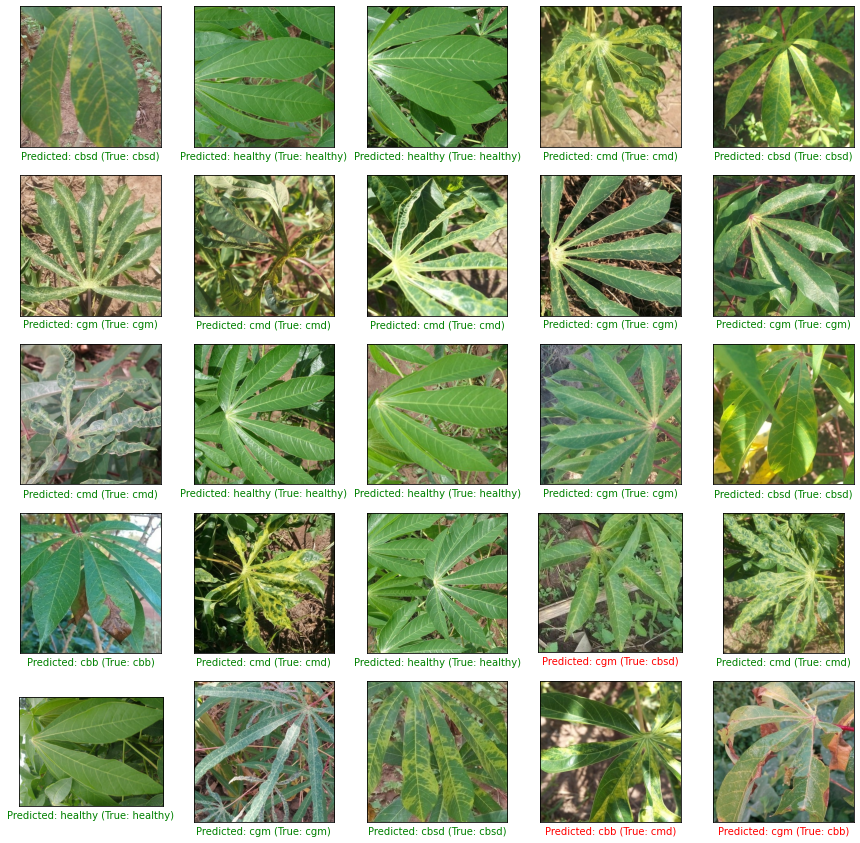

In [ ]:
plot_25_images(test_data, trained_model=model)

## Robustness of model
While our model appears to be perfoming well, our end goal is to deploy this on a smartphone and have a small holder farmer use it. One challenge we have encounted previously is the farmer will point the phone at a chair or a flower. What result will our current model give?

Lets see.

### Trying our model on a flowers dataset
Lets download a flowers dataset and see what our model gives us.

In [ ]:
image_path = tf.keras.utils.get_file(
      'flower_photos.tgz',
      'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
      extract=True)
image_path = os.path.join(os.path.dirname(image_path), 'flower_photos')

In [ ]:
flowerdata = DataLoader.from_folder(image_path)

INFO:tensorflow:Load image with size: 3670, num_label: 5, labels: daisy, dandelion, roses, sunflowers, tulips.


INFO:tensorflow:Load image with size: 3670, num_label: 5, labels: daisy, dandelion, roses, sunflowers, tulips.


In [ ]:
test_flowerdata, rest_data = flowerdata.split(0.1)

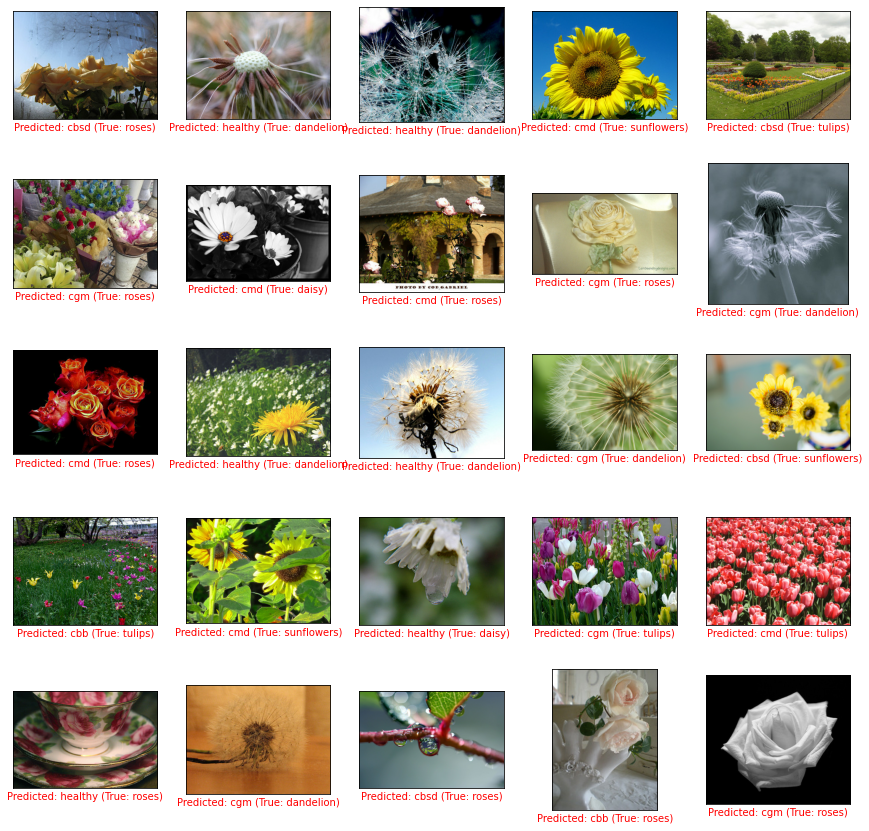

In [ ]:
plot_25_images(test_flowerdata, trained_model=model)

As expected, our model gives spurious results. The farmer at this point would say, "your thing does not work"; even if the usage has been wrong. To make the model robust you may need to add an `unknown class`. The space of unknown things is huge so you may need a large dataset. We shall leave this as an assignment.


## Making use of available resources on Tf-Hub
Luckily for crop disease detection, some work has been done in creating a large "unknown class" of images. Actually for cassava a whole model called CropNet was created and you can look through the steps of how this was created. 

We will pull it down from Tf-Hub and score our test samples with this model and see how well it does.


In [ ]:
cropnetclassifier = hub.KerasLayer('https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2')

You will need to pre-process the data to suit the input format of this model that we are downloading from Tf-Hub. Clicking on the model link will provide more information about the input formats. 

We create different preprocessing functions for our cassava dataset and our flower dataset mainly because all flowers have to be assigned a new label "unknown".

In [ ]:
def preprocess_fn(image, label):
  # Normalize [0, 255] to [0, 1]
  image = tf.cast(image, tf.float32)
  image = image / 255.

  # Resize the images to 224 x 224
  image = tf.image.resize(image, (224, 224))
  return image, label

def preprocess_fn_flower(image, label):
  # Normalize [0, 255] to [0, 1]
  image = tf.cast(image, tf.float32)
  image = image / 255.

  # Resize the images to 224 x 224
  image = tf.image.resize(image, (224, 224))

  # For the flower class we want to assign all
  # flowers the label 5 for unknown class.
  return image, 5

Determine accuracy on our cassava test data using this classifier

In [ ]:
# Calculate the accuracy of the model on test cassava data
metric = tf.keras.metrics.Accuracy()
for (image, label) in test_data.gen_dataset().map(preprocess_fn):
  probabilities = cropnetclassifier(image)
  predictions = tf.math.argmax(probabilities, axis=-1)
  metric.update_state(label, predictions)

print('Accuracy on test data: %.2f' % (metric.result().numpy()))

Accuracy on test data: 0.94


Determine the performance of the classifier on flower test data

In [ ]:
# Calculate the accuracy of the model on flower data (unknown class)
metric = tf.keras.metrics.Accuracy()
for (image, label) in test_flowerdata.gen_dataset().map(preprocess_fn_flower):
  probabilities = cropnetclassifier(image)
  predictions = tf.math.argmax(probabilities, axis=-1)
  metric.update_state(label, predictions)

print('Accuracy on test data: %.2f' % (metric.result().numpy()))

Accuracy on test data: 1.00


## Conclusion
As you can see we get better performance with our model imported from Tf-Hub. This is expected since it was trained more rigorously with alot of data. The main idea here is that we would have to make our model more robust by adding an unknown class and or selecting a different base network to fine-tune our model. These will be left as assignments. 

## Exporting model
You can export the model to tensorflow lite and use that to build a smartphone app for cassava disease classification. More information can be obtained [here](https://www.tensorflow.org/lite/models/image_classification/overview#example_applications_and_guides)

In [ ]:
model.export(export_dir='.')

# Assignments
There are a couple of things you can try on your own, ranging from getting your own data to improving the model. 
1. (Basic) You can change the base model that you are fine-tuning (EfficientNet) to something else like MobileNet and see how well the fine-tuning works. 
2. (Intermediate) You can try and use one of the crop-net models in Tf-Hub by changing the `model_spec` parameter of the model maker.
3. (Advanced) You can add an unknown class to our dataset (or your own dataset) and retrain it, and create a robust model. You can follow [this tutorial](https://colab.sandbox.google.com/drive/1CM50nVqmMD030aBun7eV47OZ7FMMw5eS?usp=drive_open) on how the CropNet model was trained.